# Utils

In [1]:
import re
import jieba

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from collections import Counter

%matplotlib inline

In [2]:
punctuation = "，。！……？（）【】~!@#$%^&*()_+`{}|\[\]\:\";\-\\\='<>?,./"

def convert_waimai_data_to_uniform_txt_corpus(file_path, is_remove_punctuation=True):
    df = pd.read_csv(file_path)
    X = df['review']
    y = df['label']

    # remove the punctuation
    X_refined = []
    for s in X:
        if is_remove_punctuation:
            s = re.sub(r'[{}]+'.format(punctuation), ' ', s)
        s = [w for w in jieba.cut(s) if w.strip()]
        X_refined.append(s)
    return X_refined, y

In [3]:
file_path = '../data/waimai_10k.csv'
waimai_data, waimai_label = convert_waimai_data_to_uniform_txt_corpus(file_path)
print('waimai_data: {}'.format(len(waimai_data)))
print('waimai_label: {}'.format(len(waimai_label)))
print('X_sample: {}, y_sample: {}'.format(waimai_data[0], waimai_label[0]))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.523 seconds.
Prefix dict has been built successfully.


waimai_data: 11987
waimai_label: 11987
X_sample: ['很快', '好吃', '味道', '足', '量', '大'], y_sample: 1


# Corpus
the class generating from copus functions

In [4]:
class Corpus(object):
    def __init__(self, corpus, vocab_size=5000):
        self.vocab_size = vocab_size
        self.corpus = corpus
        self.word_to_id, self.id_to_word, self.word_frequency = self.build_vocab()

    def build_vocab(self):
        '''
        build vocabulary for corpus
        :return:
        word_frequncy
        word_to_id
        id_to_word
        '''
        words = []
        word_to_id = {'<UNK>': 0, '<START>': 1, '<END>': 2, '<PAD>': 3}
        id_to_word = {0: '<UNK>', 1: '<START>', 2: '<END>', 3: '<PAD>'}
        for sentence in self.corpus:
            for w in sentence:
                words.append(w)
        word_frequncy = Counter(words).most_common(self.vocab_size - len(word_to_id))
        for idx, (k, v) in enumerate(word_frequncy):
            word_to_id[k] = idx + 4
            id_to_word[idx+4] = k
        return word_to_id, id_to_word, word_frequncy

    def encoding_corpus_to_index(self, max_sentence_len):
        '''

        :param max_sentence_len:
        :return:
        '''
        corpus_to_id = []
        for s in self.corpus:
            s_refined = []
            for w in s[:max_sentence_len]:
                if w in self.word_to_id.keys():
                    s_refined.append(self.word_to_id[w])
                else:
                    s_refined.append(self.word_to_id['<UNK>'])
            if len(s_refined) < max_sentence_len:
                for i in range(max_sentence_len-len(s_refined)):
                    s_refined.append(self.word_to_id['<PAD>'])
            corpus_to_id.append(s_refined)
        return corpus_to_id

In [5]:
max_sentence_len=15
corpus = Corpus(waimai_data, vocab_size=5000)
corpus_indexed = corpus.encoding_corpus_to_index(max_sentence_len)

In [6]:
print('word frequency: {}'.format(corpus.word_frequency[:5]))
print('index: {}'.format(corpus_indexed[0]))
print('string: {}'.format([corpus.id_to_word[id] for id in corpus_indexed[0]]))

word frequency: [('了', 9398), ('的', 7840), ('很', 2244), ('都', 2182), ('是', 2144)]
index: [55, 16, 14, 301, 90, 106, 3, 3, 3, 3, 3, 3, 3, 3, 3]
string: ['很快', '好吃', '味道', '足', '量', '大', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


# Text Classification

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

Using TensorFlow backend.


In [8]:
def build_model(vocab_size, max_sentence_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 8, input_length=max_sentence_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


def train(model, X, y, epochs=50):
    history = model.fit(X, y, epochs=50)
    return model, history


def predict(model, X):
    return model.predict(X)

In [9]:
model = build_model(corpus.vocab_size, max_sentence_len)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 8)             40000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 40,121
Trainable params: 40,121
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
X = np.asarray(corpus_indexed)
y = np.asarray(waimai_label)
X.shape, y.shape

((11987, 15), (11987,))

In [11]:
model, history = train(model, X, y)

/root/wind/env/wind_py3_comm/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
11987/11987 [==============================] - 1s 69us/step - loss: 0.5592 - accuracy: 0.7417
Epoch 2/50
11987/11987 [==============================] - 1s 51us/step - loss: 0.3422 - accuracy: 0.8690
Epoch 3/50
11987/11987 [==============================] - 1s 50us/step - loss: 0.2753 - accuracy: 0.8988
Epoch 4/50
11987/11987 [==============================] - 1s 49us/step - loss: 0.2392 - accuracy: 0.9132
Epoch 5/50
11987/11987 [==============================] - 1s 49us/step - loss: 0.2136 - accuracy: 0.9233
Epoch 6/50
11987/11987 [==============================] - 1s 51us/step - loss: 0.1928 - accuracy: 0.9323
Epoch 7/50
11987/11987 [==============================] - 1s 51us/step - loss: 0.1752 - accuracy: 0.9384
Epoch 8/50
11987/11987 [==============================] - 1s 52us/step - loss: 0.1597 - accuracy: 0.9467
Epoch 9/50
11987/11987 [==============================] - 1s 54us/step - loss: 0.1464 - accuracy: 0.9517
Epoch 10/50
11987/11987 [==============================

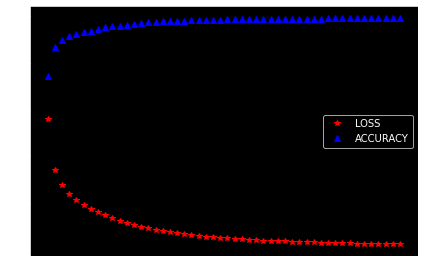

In [12]:
plt.plot(history.history['loss'], 'r*', label='LOSS')
plt.plot(history.history['accuracy'], 'b^', label='ACCURACY')
plt.legend()
plt.tight_layout()